In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Load embeddings and align classes

In [2]:
# load embeddings
embeddings = h5py.File('../embedding-bias/embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
irmas/yamnet
irmas/yamnet/features
irmas/yamnet/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys
openmic/yamnet
openmic/yamnet/features
openmic/yamnet/keys


In [3]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
class_map

{'cello': 3,
 'clarinet': 4,
 'flute': 7,
 'guitar': 8,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'trumpet': 16,
 'violin': 18,
 'voice': 19}

In [4]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [5]:
# use a Pandas DataFrame to record all results and save into a csv file later
result_all = pd.DataFrame({'instrument': [],
                          'train_set': [],
                          'test_set': [],
                          'precision': [],
                          'recall': [],
                          'f1-score': [],
                          'support': [],
                          'accuracy': [],
                          'roc_auc': [],
                          'ap': []
                         })

# irmas->irmas

In [6]:
# irmas: yamnet embedding
feature = np.array(embeddings['irmas']['yamnet']['features'])
keys_ori = np.array(embeddings['irmas']['yamnet']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

(33525, 1024) (33525,)
(6705,)


In [7]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
key_clip = np.array([str(k, encoding='utf-8') for k in key_clip])
print(feature_clip.shape, key_clip.shape)

  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 1024) (6705,)


In [8]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

In [9]:
# these loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(str(key_clip[k])))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [10]:
#keys = np.array([str(k, encoding='utf-8') for k in key_clip])
keys = np.array(key_clip)
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [11]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

# print out the sliced shapes as a sanity check
print(X_train.shape)
print(X_test.shape)

(5039, 1024)
(1666, 1024)


In [12]:
train_set_name, test_set_name = 'irmas', 'irmas'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()  

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_train_inst = Y_true_train==instrument
    Y_true_test_inst = Y_true_test==instrument
    
    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }  
    scoring = 'roc_auc'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)  
    
    # fit the model
    clf.fit(X_train, Y_true_train_inst)
    
    # predict
    Y_pred_test_inst = clf.predict(X_test)
    
    # Get prediction scores for the positive class
    Y_pred_test_scores = clf.predict_proba(X_test)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.90      0.94      1572
        True       0.35      0.91      0.51        94

    accuracy                           0.90      1666
   macro avg       0.67      0.91      0.73      1666
weighted avg       0.96      0.90      0.92      1666

ROC-AUC = 0.961		AP = 0.760
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.99      0.88      0.93      1539
        True       0.36      0.85      0.51       127

    accuracy                           0.87      1666
   macro avg       0.67      0.86      0.72      1666
weighted avg       0.94      0.87      0.90      1666

ROC-AUC = 0.930		AP = 0.721
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.98      0.92    

# openmic->openmic

In [13]:
# openmic: yamnet embedding
feature = np.array(embeddings['openmic']['yamnet']['features'])
keys = np.array(embeddings['openmic']['yamnet']['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)
key_clip.shape

(380000, 1024) (380000,)


(20000,)

In [14]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

key_clip = np.array([str(k, 'utf-8') for k in key_clip])

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 1024) (20000,)


In [15]:
# key-label map using the information from the dataset source
#data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'
# Replaced the above by a local symbolic link within the github repo
data_root = '../datasets/openmic-2018/'

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_true']
Ymask = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_mask']
sample_key = np.load(os.path.join(data_root, 'openmic-2018.npz'))['sample_key']

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

(20000, 20) (20000, 20) (20000,)


In [16]:
Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

X = feature_clip
del(feature_clip)

print(X.shape, Y_true.shape, Y_mask.shape)

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 1024) (20000, 20) (20000, 20)


In [17]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [18]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [19]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

print(X_train.shape); print(X_test.shape)

(14915, 1024)
(5085, 1024)


In [20]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic', 'openmic'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()  

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst = X_train[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_true_train_inst)

    # predict
    Y_pred_test_inst = clf.predict(X_test_inst)
    # Get prediction scores for the positive class
    Y_pred_test_scores = clf.predict_proba(X_test_inst)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.86      0.82      0.84       259
        True       0.81      0.84      0.82       226

    accuracy                           0.83       485
   macro avg       0.83      0.83      0.83       485
weighted avg       0.83      0.83      0.83       485

ROC-AUC = 0.911		AP = 0.886
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.91      0.67      0.77       503
        True       0.38      0.75      0.51       137

    accuracy                           0.69       640
   macro avg       0.64      0.71      0.64       640
weighted avg       0.80      0.69      0.71       640

ROC-AUC = 0.781		AP = 0.459
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.86      0.64    

# irmas->openmic

In [21]:
train_set_name, test_set_name = 'irmas', 'openmic' 

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations 
    # This is what the mask arrays are for
    test_inst = Y_mask_test[:, inst_num]

    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # evaluate the classifier 
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test_inst)
    Y_pred_test_scores =  globals()['models_'+train_set_name][instrument].predict_proba(X_test_inst)[:, 1]

    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.76      0.64      0.70       259
        True       0.65      0.77      0.71       226

    accuracy                           0.70       485
   macro avg       0.71      0.71      0.70       485
weighted avg       0.71      0.70      0.70       485

ROC-AUC = 0.763		AP = 0.727
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.85      0.78      0.81       503
        True       0.37      0.47      0.42       137

    accuracy                           0.72       640
   macro avg       0.61      0.63      0.61       640
weighted avg       0.74      0.72      0.73       640

ROC-AUC = 0.697		AP = 0.385
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.78      0.66    

# openmic->irmas

In [22]:
# irmas: yamnet embedding
feature = np.array(embeddings['irmas']['yamnet']['features'])
keys_ori = np.array(embeddings['irmas']['yamnet']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
key_clip = np.array([str(k, 'utf-8') for k in key_clip])
print(feature_clip.shape, key_clip.shape)

(33525, 1024) (33525,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 1024) (6705,)


In [23]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [24]:
keys = np.array(key_clip)
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [25]:
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

print(X_train.shape)
print(X_test.shape)

(5039, 1024)
(1666, 1024)


In [26]:
train_set_name, test_set_name = 'openmic', 'irmas' 

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_test_inst = Y_true_test==instrument

    # evaluate the classifier
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test)
    Y_pred_test_scores =  globals()['models_'+train_set_name][instrument].predict_proba(X_test)[:, 1]
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    model_auc = roc_auc_score(Y_true_test_inst, Y_pred_test_scores)
    model_ap = average_precision_score(Y_true_test_inst, Y_pred_test_scores)
    print(f'ROC-AUC = {model_auc:.3f}\t\tAP = {model_ap:.3f}')
    
    # record the result for each instrument
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    report['roc_auc'] = model_auc
    report['ap'] = model_ap
    report_accuracy = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['accuracy'][-2]
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support'], report_accuracy, model_auc, model_ap]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.99      0.72      0.84      1572
        True       0.16      0.87      0.27        94

    accuracy                           0.73      1666
   macro avg       0.57      0.80      0.55      1666
weighted avg       0.94      0.73      0.80      1666

ROC-AUC = 0.896		AP = 0.612
----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.98      0.71      0.82      1539
        True       0.19      0.86      0.32       127

    accuracy                           0.72      1666
   macro avg       0.59      0.78      0.57      1666
weighted avg       0.92      0.72      0.78      1666

ROC-AUC = 0.884		AP = 0.565
----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.99      0.51    

# Plot result on each instrument

In [27]:
# save all result into a csv file
result_all.to_csv('YAMnet_crossdataset_result.csv', index=False)

In [28]:
# check the PRF averaged over all instruments for each case:

train_irmas = result_all[result_all['train_set']=='irmas']
train_openmic = result_all[result_all['train_set']=='openmic']

irmas_irmas = train_irmas[train_irmas['test_set']=='irmas']
irmas_openmic = train_irmas[train_irmas['test_set']=='openmic']
openmic_openmic = train_openmic[train_openmic['test_set']=='openmic']
openmic_irmas = train_openmic[train_openmic['test_set']=='irmas']

print('PRF and accuracy of YAMnet averaged over all instruments for each case:')
print('openmic->openmic:{}'.format(list(openmic_openmic[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('irmas->openmic:{}'.format(list(irmas_openmic[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('irmas->irmas:{}'.format(list(irmas_irmas[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))
print('openmic->irmas:{}'.format(list(openmic_irmas[['precision', 'recall', 'f1-score', 'accuracy', 'roc_auc', 'ap']].astype(float).mean(axis=0).round(2))))

PRF and accuracy of YAMnet averaged over all instruments for each case:
openmic->openmic:[0.75, 0.85, 0.79, 0.82, 0.9, 0.83]
irmas->openmic:[0.71, 0.74, 0.72, 0.77, 0.83, 0.76]
irmas->irmas:[0.53, 0.86, 0.64, 0.91, 0.95, 0.79]
openmic->irmas:[0.24, 0.79, 0.35, 0.72, 0.85, 0.54]


In [38]:
# save the result of VGGish, yamnet, and OpenL3 into one csv file

vggish = pd.read_csv('VGGish_crossdataset_result.csv')
openl3 = pd.read_csv('OpenL3_crossdataset_result.csv')
yamnet = pd.read_csv('YAMnet_crossdataset_result.csv')

# add embedding information, concatenate result
vggish['embedding'] = ['vggish'] * len(vggish['instrument'])
openl3['embedding'] = ['openl3'] * len(openl3['instrument'])
yamnet['embedding'] = ['yamnet'] * len(openl3['instrument'])

result_all_conca = pd.concat([vggish, openl3, yamnet], ignore_index=True)

# move embedding to the first column
cols = ['embedding', 'instrument', 'train_set', 'test_set', 'precision', 'recall', 'f1-score', 'support', 'accuracy', 'roc_auc', 'ap']
result_all_conca =result_all_conca[cols]

result_all_conca.to_csv('crossdataset_generalization_result.csv', index=False)

In [30]:
# # check all result
# result_all_conca

In [31]:
# sns.set_theme(context='notebook', style='whitegrid', palette='deep')

# df = pd.read_csv('crossdataset_generalization_result.csv')
# sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='f1-score', hue='embedding', kind='bar');
# plt.savefig('crossdataset_generalization_f1score.png')

In [32]:
# sns.set_theme(context='notebook', style='whitegrid', palette='deep')

# df = pd.read_csv('crossdataset_generalization_result.csv')
# sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='accuracy', hue='embedding', kind='bar');
# plt.savefig('crossdataset_generalization_accuracy.png')

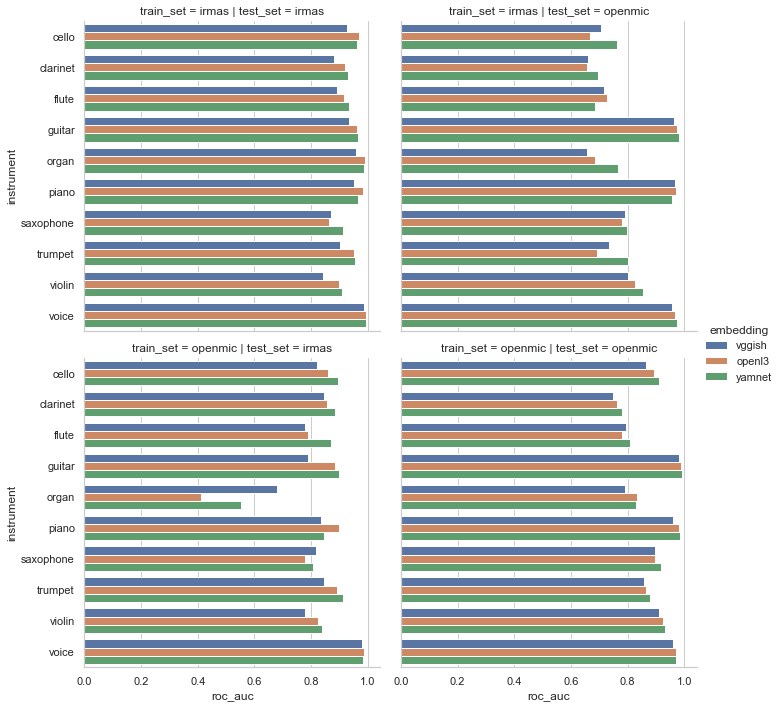

In [39]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

df = pd.read_csv('crossdataset_generalization_result.csv')
sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar');
plt.savefig('crossdataset_generalization_auc.png')

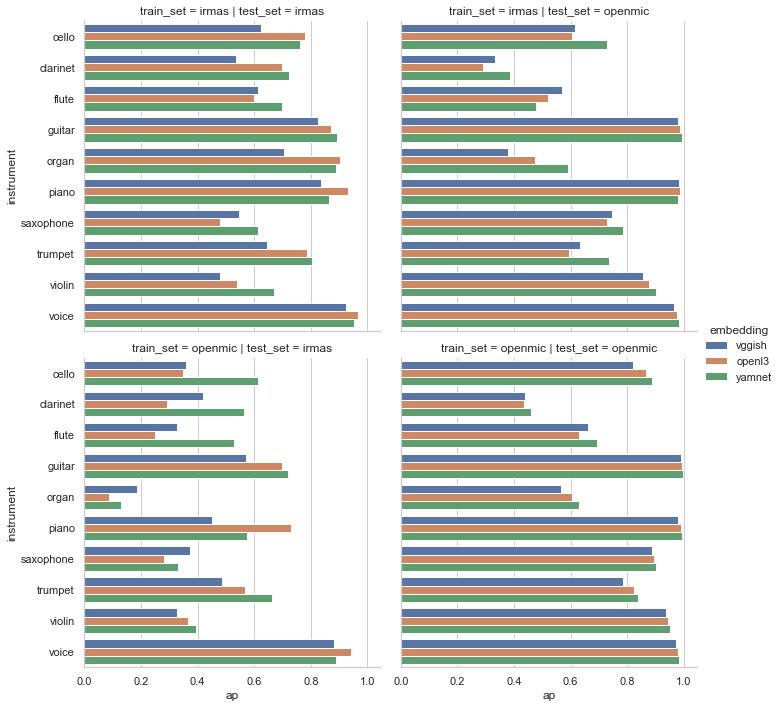

In [40]:
sns.set_theme(context='notebook', style='whitegrid', palette='deep')

df = pd.read_csv('crossdataset_generalization_result.csv')
sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='ap', hue='embedding', kind='bar');
plt.savefig('crossdataset_generalization_ap.png')

# Save models

In [35]:
import pickle

In [36]:
with open('models_irmas_yamnet.pickle', 'wb') as fdesc:
    pickle.dump(models_irmas, fdesc)

In [37]:
with open('models_openmic_yamnet.pickle', 'wb') as fdesc:
    pickle.dump(models_openmic, fdesc)